<a href="https://colab.research.google.com/github/OceanZhang1988/CS4641/blob/main/LinearModels_release.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Licensing Information:  You are free to use or extend this project for
# educational purposes provided that (1) you do not distribute or publish
# solutions, (2) you retain this notice, and (3) you provide clear
# attribution to The Georgia Institute of Technology, including a link to https://aritter.github.io/CS-4641/

# Attribution Information: This assignment was developed at The Georgia Institute of Technology
# by Alan Ritter (alan.ritter@cc.gatech.edu)

#Project \#2: Linear Models

In this assignment you will train linear models using stochastic gradient descent to predict whether a human subject is viewing a picture or reading a sentence from their fMRI brain image data.

NOTE: It may take some time to run the experiments for this assignment, so we recommend that you start early. We also recommend doing as much computation as possible using Numpy vector and matrix operations, this will be much faster than, for example writing loops to compute dot products in Python. You can find more details about Numpy [online](https://numpy.org/doc/stable/user/quickstart.html).

# Downloading the fMRI Data

The data you will use for this assignment comes from the [starplus dataset](http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-81/www/) (only the first subject). We provide starter code to read the provided matlab file into Python/Numpy arrays. The data for each trial consists of a sequence of brain images that we have flattened into a feature vector X. Your task is to train a linear classifier that outputs, $y \in {+1,-1}$, which correspond to whether the subject was first shown a picture or a sentence during the trial. More details on the dataset are included in the comments of the starter code and in the [README file](http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-81/www/README-data-documentation.txt).

In [ ]:
#Download the data
!wget https://github.com/aritter/CS-4641/raw/main/data/data-starplus-04847-v7.mat

--2021-10-11 00:49:49--  https://github.com/aritter/CS-4641/raw/main/data/data-starplus-04847-v7.mat
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aritter/CS-4641/main/data/data-starplus-04847-v7.mat [following]
--2021-10-11 00:49:50--  https://raw.githubusercontent.com/aritter/CS-4641/main/data/data-starplus-04847-v7.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102283661 (98M) [application/octet-stream]
Saving to: ‘data-starplus-04847-v7.mat.1’

data-starplus-04847 100%[===================>]  97.54M   220MB/s    in 0.4s    

2021-10-11 00:49:50 (220 MB/s) - ‘data-starplus-04847-v7.mat.

# Reading in the Dataset

The code below reads in the Matlab (.mat) formatted file that was downloaded above, and extracts the raw fMRI data, in addition to metadata into appropriate Python data structures.  Your goal in this assignment will be to implement linear classifiers, and measure their accuracy at predicting whether the subject first viewed a picture ('P'), or sentence ('S'), from raw fMRI brain image data.

In [ ]:
import scipy.io as sio
import numpy as np

import os

starplus = sio.loadmat("data-starplus-04847-v7.mat", verify_compressed_data_integrity=False)

###########################################
metadata = starplus['meta'][0,0]
#meta.study gives the name of the fMRI study
#meta.subject gives the identifier for the human subject
#meta.ntrials gives the number of trials in this dataset
#meta.nsnapshots gives the total number of images in the dataset
#meta.nvoxels gives the number of voxels (3D pixels) in each image
#meta.dimx gives the maximum x coordinate in the brain image. The minimum x coordinate is x=1. meta.dimy and meta.dimz give the same information for the y and z coordinates.
#meta.colToCoord(v,:) gives the geometric coordinate (x,y,z) of the voxel corresponding to column v in the data
#meta.coordToCol(x,y,z) gives the column index (within the data) of the voxel whose coordinate is (x,y,z)
#meta.rois is a struct array defining a few dozen anatomically defined Regions Of Interest (ROIs) in the brain. Each element of the struct array defines on of the ROIs, and has three fields: "name" which gives the ROI name (e.g., 'LIFG'), "coords" which gives the xyz coordinates of each voxel in that ROI, and "columns" which gives the column index of each voxel in that ROI.
#meta.colToROI{v} gives the ROI of the voxel corresponding to column v in the data.
study      = metadata['study']
subject    = metadata['subject']
ntrials    = metadata['ntrials'][0][0]
nsnapshots = metadata['nsnapshots'][0][0]
dimx       = metadata['dimx'][0][0]
colToCoord = metadata['colToCoord']
coordToCol = metadata['coordToCol']
rois       = metadata['rois']
colToROI   = metadata['colToROI']
###########################################

###########################################
info = starplus['info'][0]
#info: This variable defines the experiment in terms of a sequence of 'trials'. 'info' is a 1x54 struct array, describing the 54 time intervals, or trials. Most of these time intervals correspond to trials during which the subject views a single picture and a single sentence, and presses a button to indicate whether the sentence correctly describes the picture. Other time intervals correspond to rest periods. The relevant fields of info are illustrated in the following example:
#info(18) mint: 894 maxt: 948 cond: 2 firstStimulus: 'P' sentence: ''It is true that the star is below the plus.'' sentenceRel: 'below' sentenceSym1: 'star' sentenceSym2: 'plus' img: sap actionAnswer: 0 actionRT: 3613
#info.mint gives the time of the first image in the interval (the minimum time)
#info.maxt gives the time of the last image in the interval (the maximum time)
#info.cond has possible values 0,1,2,3. Cond=0 indicates the data in this segment should be ignored. Cond=1 indicates the segment is a rest, or fixation interval. Cond=2 indicates the interval is a sentence/picture trial in which the sentence is not negated. Cond=3 indicates the interval is a sentence/picture trial in which the sentence is negated.
#info.firstStimulus: is either 'P' or 'S' indicating whether this trail was obtained during the session is which Pictures were presented before sentences, or during the session in which Sentences were presented before pictures. The first 27 trials have firstStimulus='P', the remained have firstStimulus='S'. Note this value is present even for trials that are rest trials. You can pick out the trials for which sentences and pictures were presented by selecting just the trials trials with info.cond=2 or info.cond=3.
#info.sentence gives the sentence presented during this trial. If none, the value is '' (the empty string). The fields info.sentenceSym1, info.sentenceSym2, and info.sentenceRel describe the two symbols mentioned in the sentence, and the relation between them.
#info.img describes the image presented during this trial. For example, 'sap' means the image contained a 'star above plus'. Each image has two tokens, where one is above the other. The possible tokens are star (s), plus (p), and dollar (d).
#info.actionAnswer: has values -1 or 0. A value of 0 indicates the subject is expected to press the answer button during this trial (either the 'yes' or 'no' button to indicate whether the sentence correctly describes the picture). A value of -1 indicates it is inappropriate for the subject to press the answer button during this trial (i.e., it is a rest, or fixation trial).
#info.actionRT: gives the reaction time of the subject, measured as the time at which they pressed the answer button, minus the time at which the second stimulus was presented. Time is in milliseconds. If the subject did not press the button at all, the value is 0.
###########################################

###########################################
data = starplus['data']
#data: This variable contains the raw observed data. The fMRI data is a sequence of images collected over time, one image each 500 msec. The data structure 'data' is a [54x1] cell array, with one cell per 'trial' in the experiment. Each element in this cell array is an NxV array of observed fMRI activations. The element data{x}(t,v) gives the fMRI observation at voxel v, at time t within trial x. Here t is the within-trial time, ranging from 1 to info(x).len. The full image at time t within trial x is given by data{x}(t,:).
#Note the absolute time for the first image within trial x is given by info(x).mint.
###########################################

Below we create a matrix of features, $X$, and vector of labels, $Y$, which indicates whether the subject first viewed an image or a picture.


In [ ]:
maxFeatures =  max([data[i][0].flatten().shape[0] for i in range(data.shape[0])])

#Inputs
X = np.zeros((ntrials, maxFeatures+1))
for i in range(data.shape[0]):
    f = data[i][0].flatten()
    X[i,:f.shape[0]] = f
    X[i,f.shape[0]]  = 1     #Bias

#Outputs (+1 = Picture, -1 = Sentence)
Y = np.ones(ntrials)
Y[np.array([info[i]['firstStimulus'][0] != 'P' for i in range(ntrials)])] = -1

#Logistic Regression (10 points)

Recall the regularized logistic loss that we discussed in class (taken from Logistic Regression):

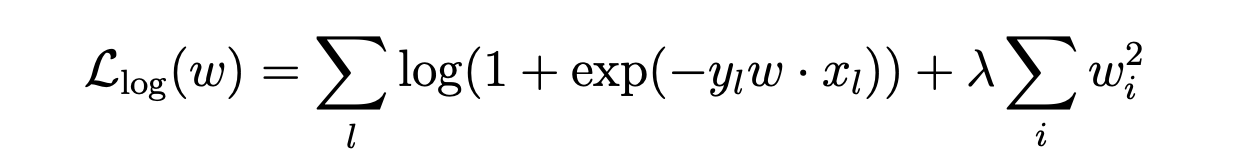

Your task is to implement stochastic gradient descent for the logistic loss by completing the associated sections in the starter code below.  

First implement LogisticLoss.  This function should return the total loss for a dataset given a specific set of weights. This is useful for monitoring convergence during gradient descent.

Next, fill in the missing part of the associated gradient descent routine (SgdLogistic).

In [ ]:
def LogisticLoss(X, Y, W, lmda):
    #TODO: Compute (regularized) Logistic Loss
    loss = 0
    return loss

def SgdLogistic(X, Y, maxIter, learningRate, lmda):
    W = np.zeros(X.shape[1])
    #TODO: implement stochastic gradient descent using the logistic loss function
    return W

def crossValidation(X, Y, SGD, lmda, learningRate, maxIter=20, sample=range(20)):
    #Leave one out cross validation accuracy
    nCorrect   = 0.
    nIncorrect = 0.
    
    for i in sample:
        print("CROSS VALIDATION %s" % i)
        
        training_indices = [j for j in range(X.shape[0]) if j != i]
        W = SGD(X[training_indices,], Y[training_indices,], maxIter=maxIter, lmda=lmda, learningRate=learningRate)
        y_hat = np.sign(X[i,].dot(W))
        if y_hat == 0.0:
          y_hat = -1.0

        if y_hat == Y[i]:
            nCorrect += 1
        else:
            nIncorrect += 1

    return nCorrect / (nCorrect + nIncorrect)

#Parameter Tuning (6 Points)

After implementing the loss and gradients you are now ready to train your models. 

Because time on an fMRI machine is expensive, there are only a relatively small number of trials available for each subject (only 54 examples of a person viewing a picture and reading a sentence).  To make the most of this small amount of data, we have provided you with code for hold-one-out cross validation.

In hold-one-out cross validation, you can use all of your data for training (except one trial), and also compute the accuracy of your classifier on the entire dataset.  This works by training 54 different classifiers - each is trained on 53 training examples and tested on a single example.  Then you can calculate the accuracy of your classifier on the full dataset by comparing each held-out datapoint against the gold label in the data (whether the subject first viewed a picture or read a sentence).

Tune the learning rate, $\eta$, and regularization param- eters $\lambda$ for each loss on the development set (the first 20 trials).  Try out several values, for example $\eta \in \{0.1, 0.01, 0.001, 0.0001\}$, and $\lambda \in \{1, 0.3, 0.1\}$.  Run SGD for a fixed number of iterations (e.g. 100) and print out the loss at the end of each iteration.  If your learning rate is set appropriately, the loss should be decreasing at every iteration.

In [ ]:
#Randomly permute the data
permutation = np.random.permutation(ntrials)
permutation = np.random.permutation(X.shape[0])
X = X[permutation,]
Y = Y[permutation,]

In [ ]:
#TODO: tune lambda and learning rate
LMDA=0
LEARNING_RATE=0

#Cross validation
#Development
print("Accuracy (Logistic Loss):\t%s" % crossValidation(X, Y, SgdLogistic, maxIter=20, lmda=LMDA, learningRate=LEARNING_RATE, sample=range(20)))
    

CROSS VALIDATION 0
CROSS VALIDATION 1
CROSS VALIDATION 2
CROSS VALIDATION 3
CROSS VALIDATION 4
CROSS VALIDATION 5
CROSS VALIDATION 6
CROSS VALIDATION 7
CROSS VALIDATION 8
CROSS VALIDATION 9
CROSS VALIDATION 10
CROSS VALIDATION 11
CROSS VALIDATION 12
CROSS VALIDATION 13
CROSS VALIDATION 14
CROSS VALIDATION 15
CROSS VALIDATION 16
CROSS VALIDATION 17
CROSS VALIDATION 18
CROSS VALIDATION 19
Accuracy (Logistic Loss):	0.5


# Test data

Now that you have tuned the parameters of your model on the development data, use the same hyperparameters to estimate performance on the test data (trials 20 through 54):

In [ ]:
#Test
print("Accuracy (Logistic Loss):\t%s" % crossValidation(X, Y, SgdLogistic, maxIter=20, lmda=LMDA, learningRate=LEARNING_RATE, sample=range(20,X.shape[0])))

CROSS VALIDATION 20
CROSS VALIDATION 21
CROSS VALIDATION 22
CROSS VALIDATION 23
CROSS VALIDATION 24
CROSS VALIDATION 25
CROSS VALIDATION 26
CROSS VALIDATION 27
CROSS VALIDATION 28
CROSS VALIDATION 29
CROSS VALIDATION 30
CROSS VALIDATION 31
CROSS VALIDATION 32
CROSS VALIDATION 33
CROSS VALIDATION 34
CROSS VALIDATION 35
CROSS VALIDATION 36
CROSS VALIDATION 37
CROSS VALIDATION 38
CROSS VALIDATION 39
CROSS VALIDATION 40
CROSS VALIDATION 41
CROSS VALIDATION 42
CROSS VALIDATION 43
CROSS VALIDATION 44
CROSS VALIDATION 45
CROSS VALIDATION 46
CROSS VALIDATION 47
CROSS VALIDATION 48
CROSS VALIDATION 49
CROSS VALIDATION 50
CROSS VALIDATION 51
CROSS VALIDATION 52
CROSS VALIDATION 53
Accuracy (Logistic Loss):	0.5


# Hinge Loss (10 points)

Now do the same thing you did above for the Hinge-Loss from linear soft-margin SVMs:

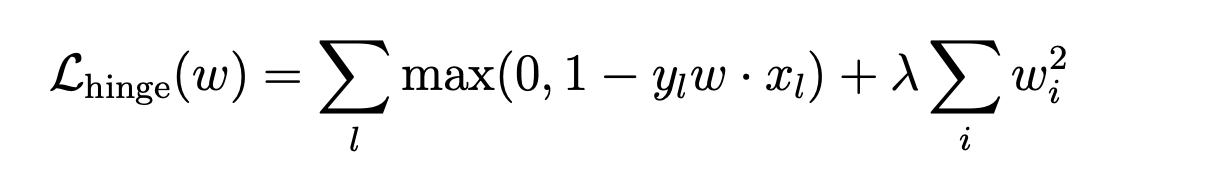

In [ ]:
def HingeLoss(X, Y, W, lmda):
    #TODO: Compute (regularized) Hinge Loss
    loss = 0
    return loss

def SgdHinge(X, Y, maxIter, learningRate=0.0001, lmda=10.):
    W = np.zeros(X.shape[1])
    #TODO: implement stochastic (sub) gradient descent with the hinge loss function
    return W

#Hyperparameter tuning (5 points)

Tune the hyperparameters on the development set.

In [ ]:
#TODO: tune lambda and learning rate
LMDA=0
LEARNING_RATE=0

#Development
print("Accuracy (Hinge Loss):\t%s" % crossValidation(X, Y, SgdHinge, maxIter=20, lmda=LMDA, learningRate=LEARNING_RATE, sample=range(20)))

CROSS VALIDATION 0
CROSS VALIDATION 1
CROSS VALIDATION 2
CROSS VALIDATION 3
CROSS VALIDATION 4
CROSS VALIDATION 5
CROSS VALIDATION 6
CROSS VALIDATION 7
CROSS VALIDATION 8
CROSS VALIDATION 9
CROSS VALIDATION 10
CROSS VALIDATION 11
CROSS VALIDATION 12
CROSS VALIDATION 13
CROSS VALIDATION 14
CROSS VALIDATION 15
CROSS VALIDATION 16
CROSS VALIDATION 17
CROSS VALIDATION 18
CROSS VALIDATION 19
Accuracy (Hinge Loss):	0.5


# Test set results

Report results on the test set (trials 20 through 53)

In [ ]:
#Test
print("Accuracy (Hinge Loss):\t%s" % crossValidation(X, Y, SgdHinge, maxIter=20, lmda=LMDA, learningRate=LEARNING_RATE, sample=range(20,X.shape[0])))

CROSS VALIDATION 20
CROSS VALIDATION 21
CROSS VALIDATION 22
CROSS VALIDATION 23
CROSS VALIDATION 24
CROSS VALIDATION 25
CROSS VALIDATION 26
CROSS VALIDATION 27
CROSS VALIDATION 28
CROSS VALIDATION 29
CROSS VALIDATION 30
CROSS VALIDATION 31
CROSS VALIDATION 32
CROSS VALIDATION 33
CROSS VALIDATION 34
CROSS VALIDATION 35
CROSS VALIDATION 36
CROSS VALIDATION 37
CROSS VALIDATION 38
CROSS VALIDATION 39
CROSS VALIDATION 40
CROSS VALIDATION 41
CROSS VALIDATION 42
CROSS VALIDATION 43
CROSS VALIDATION 44
CROSS VALIDATION 45
CROSS VALIDATION 46
CROSS VALIDATION 47
CROSS VALIDATION 48
CROSS VALIDATION 49
CROSS VALIDATION 50
CROSS VALIDATION 51
CROSS VALIDATION 52
CROSS VALIDATION 53
Accuracy (Hinge Loss):	0.5


## Submission

Please submit this notebook along with the cell outputs on Gradescope:
* LinearModels_Release.ipynb

To download this notebook, go to `File > Download.ipynb`.

When submitting the .ipynb notebook, please make sure that all the cells run when executed in order starting from a fresh session. If the code doesn't take too long to run, you can re-run everything with `Runtime -> Restart and run all`

You can submit multiple times before the deadline and choose the submission which you want to be graded by going to `Submission History` on gradescope.

